# Analysis

## Calculation of Accuracy and confusion matrix

In [ ]:
# imports and constants
import sys
sys.path.append('../')
import oncoprompt_lib as opl
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# load sql query from file
with open('AnalysisScriptMain.sql', 'r') as file:
    sql_query = file.read()
with open('AnalysisGoldData.sql', 'r') as file:
    sql_query2 = file.read()
# Select table into dataframe from duckdb

conn=opl.get_duckdb_connection(db_file='data/llmresults.duckdb')
df=conn.execute(sql_query).fetch_df()
gold=conn.execute(sql_query2).fetch_df()
conn.close()

df_final=df.query('runid in ["1: ZeroShot", "2: FewShot", "3: RAG Pipeline"]')

def draw_heatmap(data, **kwargs):
    cf=data["Confusion_Matrix"].values[0]
    blanks = ['' for i in range(cf.size)]
    labels = ["True Neg","False Pos","False Neg","True Pos"]
    categories = ["False", "True"]
    group_labels = ["{}\n".format(value) for value in labels]
    group_counts = blanks
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    cmap='YlGn'
    cbar=False
    #Accuracy is sum of diagonal divided by total observations
    accuracy  = np.trace(cf) / float(np.sum(cf))
    #Metrics for Binary Confusion Matrices
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    plt.xlabel(stats_text)

    # Colors
    sns.set_palette(sns.color_palette(palette='deep'))

In [2]:
# other functions
# Function to compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def compute_metrics(group):
    acc = accuracy_score(group['Ref_Bool'], group['Pred_Boll'])
    prec = precision_score(group['Ref_Bool'], group['Pred_Boll'], pos_label='True')
    rec = recall_score(group['Ref_Bool'], group['Pred_Boll'], pos_label='True')
    f1 = f1_score(group['Ref_Bool'], group['Pred_Boll'], pos_label='True')
    return pd.Series({'accuracy': round(acc,2), 'precision': round(prec,2), 'recall': round(rec,2), 'f1_score': round(f1,2)})
# Define a function for resampling and aggregating metrics
def resample_and_compute_metrics(group, n_samples=100, n_iterations=1000):
    metrics_list = []
    for _ in range(n_iterations):
        resampled_group = group.sample(n=n_samples, replace=True, random_state=None)  # Resample with replacement
        metrics = compute_metrics(resampled_group)
        metrics_list.append(metrics)
    # Compute the mean of the metrics across all iterations
    mean_metrics = pd.DataFrame(metrics_list).mean()
    mean_metrics = mean_metrics.round(2)  # Round the results
    return mean_metrics

# Gold Dataset

            Parent                Entity  counts
0       Metastasis            Metastasis      55
1     No Diagnosis          No Diagnosis      29
2            Solid      Bladder / Kidney      24
3            Solid    Bone / Soft Tissue      46
4            Solid           Breast/DCIS      37
5            Solid  Gynecological Tumors      69
6            Solid         Head and Neck      88
7            Solid             Intestine      28
8            Solid    Liver/Gall Bladder      14
9            Solid                  Lung      35
10           Solid        Male Genitalia      10
11           Solid        NeuroEndocrine       6
12           Solid                Others       8
13           Solid              Pancreas      11
14           Solid           Skin Tumors      27
15           Solid        Upper GI Tract      21
16  haematological             Lymphomas      15


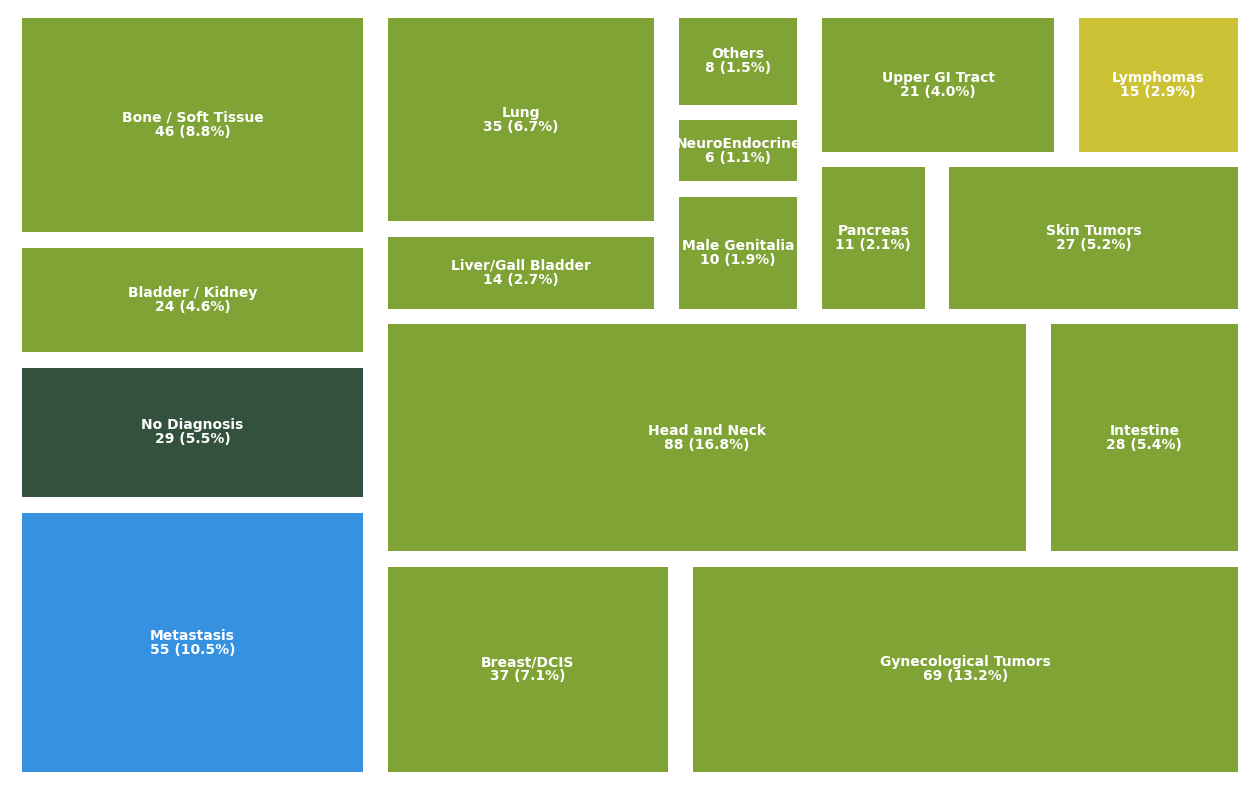

In [3]:
ents=pd.read_csv("data/entities_icd.csv",sep=";")
gold_df=gold.merge(ents,how="left",on="ICD")
icdgrp= gold_df.groupby(['Parent','Entity']).size().reset_index(name='counts')
print(icdgrp)
total_counts = icdgrp['counts'].sum()
icdgrp['perclab']=icdgrp.apply(lambda row: f"{row['counts']} ({(row['counts'] / total_counts) * 100:.1f}%)", axis=1)
import squarify
from pypalettes import load_cmap
# create a color palette
cmap = load_cmap('Acanthurus_coeruleus')
category_codes, unique_categories = pd.factorize(icdgrp['Parent'])
colors = [cmap(code) for code in category_codes]
fig, ax = plt.subplots(figsize=(16,10))
ax.set_axis_off()
squarify.plot(sizes=icdgrp['counts']
              , label=icdgrp['Entity']
              , alpha=.8
               , color=colors
               ,value=icdgrp['perclab']
              ,text_kwargs={'color':'white','fontsize':10,
                    'fontweight':'bold'}
              ,pad=True
              
              ,ax=ax )

plt.show()

# Feature Abundance

Occurance,False,True
Feature_Label,,
ICD-O Morphology,5.0,517.0
ICD-O Topography,41.0,481.0
ICD10,71.0,451.0
Grading,204.0,318.0
T category,240.0,282.0
VI,262.0,260.0
LI,272.0,250.0
PNI,289.0,233.0
N category,315.0,207.0


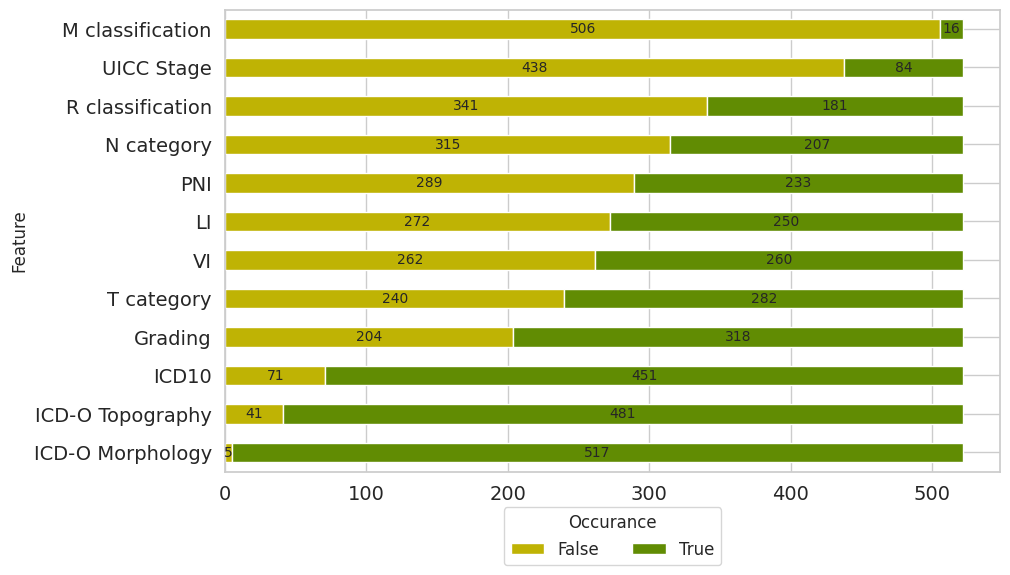

In [ ]:
features=df[["reportid","Feature_Label","Ref_Bool"]].drop_duplicates()
fdf=features.groupby(["Feature_Label","Ref_Bool"]).count().reset_index(names=["Feature_Label","Occurance","Count"])
               # Pivot the DataFrame
df_pivot = fdf.pivot_table(index='Occurance', columns='Feature_Label', values='reportid')  

df_features=df_pivot.transpose()  
df_features["True_Perc"]=df_features["True"]/(df_features["True"]+df_features["False"])   
df_features["Counts"]=(df_features["True"]+df_features["False"])                                                   

cmap = load_cmap(
   "Acanthurus_coeruleus", # Name of the palette
   keep_first_n=3, # Number of colors to keep
   reverse=True,
   shuffle=6,
   
)
# Plotting
from matplotlib.colors import ListedColormap
df_res=df_pivot.T.sort_values(by="True",ascending=False)
display(df_res)
# barplot
import matplotlib.pyplot as plt
ax =df_res.plot(kind='barh', stacked=True,figsize=(10,6),colormap=cmap,ylabel='Feature',fontsize=14)
ax.legend(
    #bbox_to_anchor=(-0.14, -0.31),
    bbox_to_anchor=(0.5, -0.22),
    fontsize=12,title='Occurance',
   loc='lower center',ncol=len(df_pivot.columns)
)
for container  in ax.containers:
    ax.bar_label(container , label_type='center',fontsize=10)  # 'center' shows labels in the middle of each bar section
plt.savefig("Feature_StackedBarplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Model Metrics

/tmp/ipykernel_1296395/2222507944.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdata = df_final.query('model in ["mistralsmall"]').groupby(["runid","LLM"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"])).reset_index(name="Confusion_Matrix")


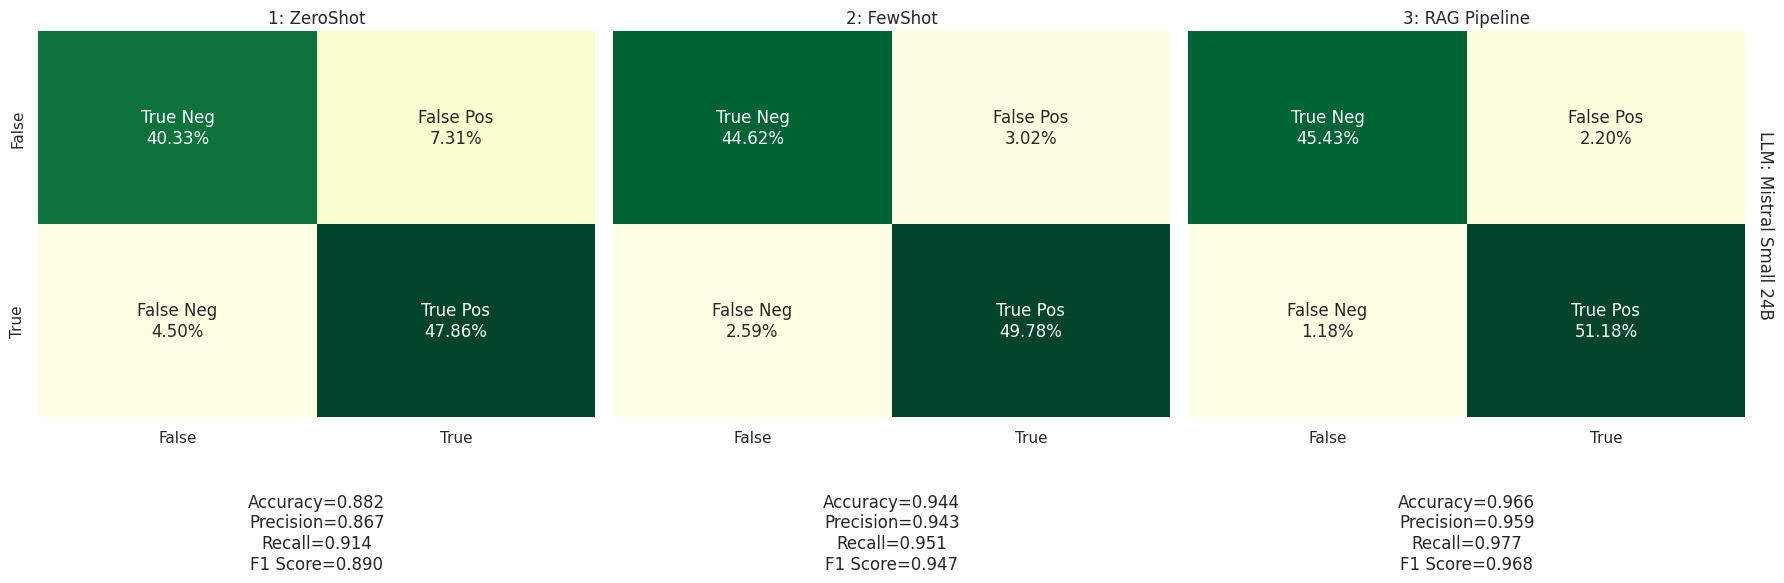

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
#['teuken7b' 'llama3_3' 'mix8x7' 'll3sauer' 'mist_nemo' 'll323b' 'deepseek_r1_8b'] "mix8x7","sauernemo",
mdata = df_final.query('model in ["mistralsmall"]').groupby(["runid","LLM"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"])).reset_index(name="Confusion_Matrix")
#mdata = df.groupby(["runid","model"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"],normalize='true')).reset_index(name="Confusion_Matrix")

m = sns.FacetGrid(mdata,col="runid", row="LLM", margin_titles=True, height=6)
m.set_titles(col_template="{col_name}",row_template="LLM: {row_name}")

m.map_dataframe(draw_heatmap)

In [10]:


tdata = df_final
df_metrics=tdata.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(compute_metrics).reset_index()
display(df_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False]))
#df_metrics.set_index(['LLM','LLM_Label','LLM_Order','runid','QueryType'],inplace=True)

print(df_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False]).to_latex(multirow=True,float_format="%.2f"))

/tmp/ipykernel_1296395/2845858698.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics=tdata.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(compute_metrics).reset_index()


,LLM,LLM_Label,LLM_Order,runid,QueryType,accuracy,precision,recall,f1_score
5,Llama 3.3 70b,Llama 3.3 70b,90,3: RAG Pipeline,RAG,0.96,0.95,0.98,0.97
4,Llama 3.3 70b,Llama 3.3 70b,90,2: FewShot,Few Shot,0.96,0.95,0.98,0.96
3,Llama 3.3 70b,Llama 3.3 70b,90,1: ZeroShot,Zero Shot,0.93,0.90,0.97,0.93
11,Mistral Small 24B,Mistral Small 24B,80,3: RAG Pipeline,RAG,0.97,0.96,0.98,0.97
10,Mistral Small 24B,Mistral Small 24B,80,2: FewShot,Few Shot,0.94,0.94,0.95,0.95
9,Mistral Small 24B,Mistral Small 24B,80,1: ZeroShot,Zero Shot,0.88,0.87,0.91,0.89
14,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,3: RAG Pipeline,RAG,0.89,0.86,0.95,0.90
13,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,2: FewShot,Few Shot,0.87,0.82,0.95,0.88
12,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,1: ZeroShot,Zero Shot,0.91,0.88,0.96,0.92
8,Mistral Nemo 12B SauerkrautLM,Mist. Nemo 12B [S],50,3: RAG Pipeline,RAG,0.93,0.91,0.96,0.93


\begin{tabular}{lllrllrrrr}
\toprule
 & LLM & LLM_Label & LLM_Order & runid & QueryType & accuracy & precision & recall & f1_score \\
\midrule
5 & Llama 3.3 70b & Llama 3.3 70b & 90 & 3: RAG Pipeline & RAG & 0.96 & 0.95 & 0.98 & 0.97 \\
4 & Llama 3.3 70b & Llama 3.3 70b & 90 & 2: FewShot & Few Shot & 0.96 & 0.95 & 0.98 & 0.96 \\
3 & Llama 3.3 70b & Llama 3.3 70b & 90 & 1: ZeroShot & Zero Shot & 0.93 & 0.90 & 0.97 & 0.93 \\
11 & Mistral Small 24B & Mistral Small 24B & 80 & 3: RAG Pipeline & RAG & 0.97 & 0.96 & 0.98 & 0.97 \\
10 & Mistral Small 24B & Mistral Small 24B & 80 & 2: FewShot & Few Shot & 0.94 & 0.94 & 0.95 & 0.95 \\
9 & Mistral Small 24B & Mistral Small 24B & 80 & 1: ZeroShot & Zero Shot & 0.88 & 0.87 & 0.91 & 0.89 \\
14 & Mixtral 8x7B SauerkrautLM & Mixtral 8x7B [S] & 70 & 3: RAG Pipeline & RAG & 0.89 & 0.86 & 0.95 & 0.90 \\
13 & Mixtral 8x7B SauerkrautLM & Mixtral 8x7B [S] & 70 & 2: FewShot & Few Shot & 0.87 & 0.82 & 0.95 & 0.88 \\
12 & Mixtral 8x7B SauerkrautLM & Mixtral 8x

In [ ]:
## Now with resampling

# Apply the resample_and_compute_metrics function to the dataframe
df_resampled_metrics = tdata.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(resample_and_compute_metrics).reset_index()

display(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False]))
print(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False])[['LLM_Label', 'QueryType' , 'accuracy' , 'precision' ,'recall' ,'f1_score']].to_latex(multirow=True,float_format="%.2f"))



/tmp/ipykernel_4027314/1942972416.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_resampled_metrics = tdata.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(resample_and_compute_metrics).reset_index()


,LLM,LLM_Label,LLM_Order,runid,QueryType,accuracy,precision,recall,f1_score
5,Llama 3.3 70b,Llama 3.3 70b,90,3: RAG Pipeline,RAG,0.97,0.95,0.98,0.97
4,Llama 3.3 70b,Llama 3.3 70b,90,2: FewShot,Few Shot,0.96,0.95,0.98,0.96
3,Llama 3.3 70b,Llama 3.3 70b,90,1: ZeroShot,Zero Shot,0.93,0.90,0.97,0.93
11,Mistral Small 24B,Mistral Small 24B,80,3: RAG Pipeline,RAG,0.97,0.96,0.98,0.97
10,Mistral Small 24B,Mistral Small 24B,80,2: FewShot,Few Shot,0.94,0.94,0.95,0.95
9,Mistral Small 24B,Mistral Small 24B,80,1: ZeroShot,Zero Shot,0.88,0.87,0.91,0.89
14,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,3: RAG Pipeline,RAG,0.89,0.86,0.95,0.90
13,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,2: FewShot,Few Shot,0.87,0.82,0.95,0.88
12,Mixtral 8x7B SauerkrautLM,Mixtral 8x7B [S],70,1: ZeroShot,Zero Shot,0.91,0.88,0.96,0.92
8,Mistral Nemo 12B SauerkrautLM,Mist. Nemo 12B [S],50,3: RAG Pipeline,RAG,0.93,0.91,0.96,0.93


\begin{tabular}{lllrrrr}
\toprule
 & LLM_Label & QueryType & accuracy & precision & recall & f1_score \\
\midrule
5 & Llama 3.3 70b & RAG & 0.97 & 0.95 & 0.98 & 0.97 \\
4 & Llama 3.3 70b & Few Shot & 0.96 & 0.95 & 0.98 & 0.96 \\
3 & Llama 3.3 70b & Zero Shot & 0.93 & 0.90 & 0.97 & 0.93 \\
11 & Mistral Small 24B & RAG & 0.97 & 0.96 & 0.98 & 0.97 \\
10 & Mistral Small 24B & Few Shot & 0.94 & 0.94 & 0.95 & 0.95 \\
9 & Mistral Small 24B & Zero Shot & 0.88 & 0.87 & 0.91 & 0.89 \\
14 & Mixtral 8x7B [S] & RAG & 0.89 & 0.86 & 0.95 & 0.90 \\
13 & Mixtral 8x7B [S] & Few Shot & 0.87 & 0.82 & 0.95 & 0.88 \\
12 & Mixtral 8x7B [S] & Zero Shot & 0.91 & 0.88 & 0.96 & 0.92 \\
8 & Mist. Nemo 12B [S] & RAG & 0.93 & 0.91 & 0.96 & 0.93 \\
7 & Mist. Nemo 12B [S] & Few Shot & 0.91 & 0.89 & 0.95 & 0.92 \\
6 & Mist. Nemo 12B [S] & Zero Shot & 0.87 & 0.84 & 0.92 & 0.88 \\
2 & Llama 3.1 8B [S] & RAG & 0.82 & 0.77 & 0.93 & 0.84 \\
1 & Llama 3.1 8B [S] & Few Shot & 0.73 & 0.71 & 0.85 & 0.77 \\
0 & Llama 3.1 8B [S]

In [ ]:
## Calculationterate over each feature
all_features = tdata['Feature'].unique()
print(all_features)
# Apply the resample_and_compute_metrics function to the dataframe
for feature in all_features:
    feature_data = tdata[tdata['Feature'] == feature]
    if len(feature_data) > 0:
        df_resampled_metrics = feature_data.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(resample_and_compute_metrics).reset_index()
        print(f"Feature: {feature}")
        #display(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False]))
        print(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False])[['LLM_Label', 'QueryType' , 'accuracy' , 'precision' ,'recall' ,'f1_score']].to_latex(multirow=True,float_format="%.2f",caption=f"Metrics for feature: {feature}"))
#df_resampled_metrics = tdata.groupby(['LLM','LLM_Label','LLM_Order','runid','QueryType']).apply(resample_and_compute_metrics).reset_index()

#display(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False]))
#print(df_resampled_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[False,False])[['LLM_Label', 'QueryType' , 'accuracy' , 'precision' ,'recall' ,'f1_score']].to_latex(multirow=True,float_format="%.2f"))

index                                0
LLM          Llama 3.1 SauerkrautLM 8B
LLM_Label             Llama 3.1 8B [S]
LLM_Order                           20
runid                      1: ZeroShot
QueryType                    Zero Shot
accuracy                          0.62
precision                         0.59
recall                            0.88
f1_score                          0.71
Name: 0, dtype: object
index                                1
LLM          Llama 3.1 SauerkrautLM 8B
LLM_Label             Llama 3.1 8B [S]
LLM_Order                           20
runid                       2: FewShot
QueryType                     Few Shot
accuracy                          0.73
precision                         0.71
recall                            0.85
f1_score                          0.77
Name: 1, dtype: object
index                                2
LLM          Llama 3.1 SauerkrautLM 8B
LLM_Label             Llama 3.1 8B [S]
LLM_Order                           20
runid             

<Figure size 1920x1440 with 0 Axes>

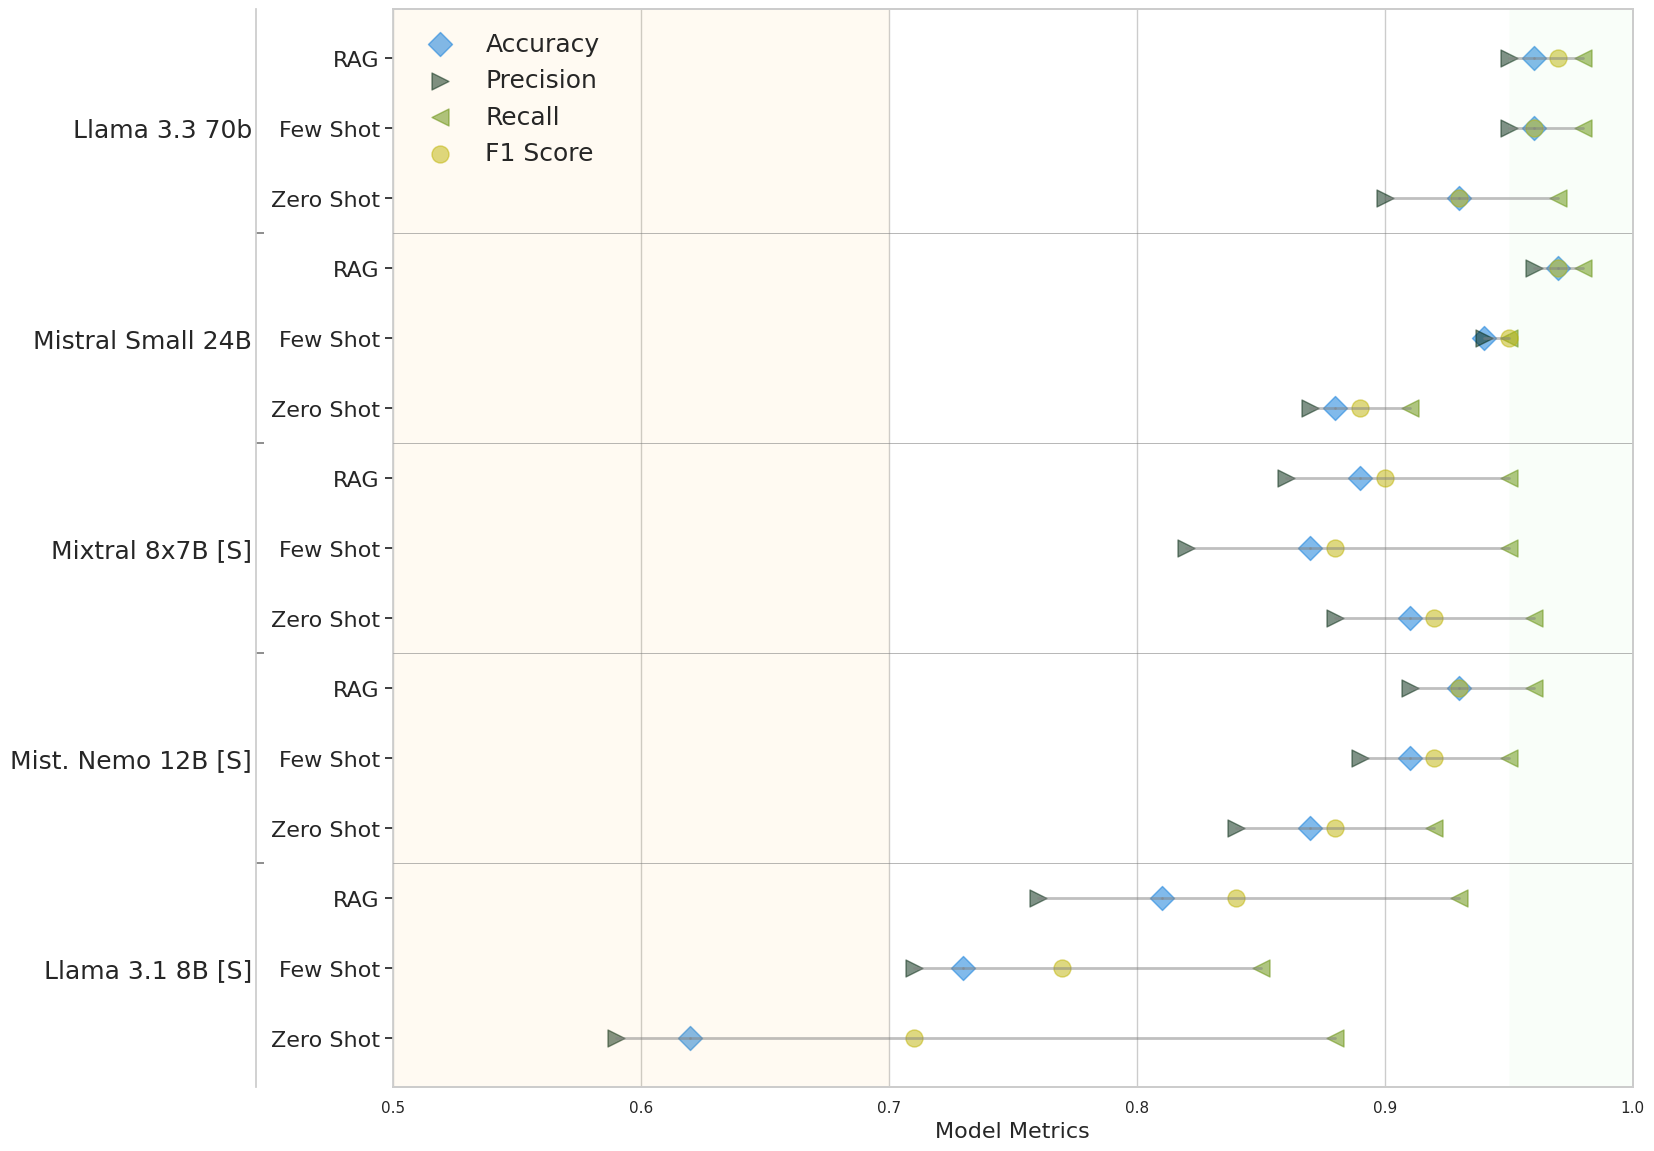

In [20]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

cmap = load_cmap(
   "Acanthurus_coeruleus", # Name of the palette
   keep_first_n=4, # Number of colors to keep
   )
palette=cmap.colors
plt.figure(dpi=300)
fig, ax = plt.subplots(figsize=(16, 14))

ax.grid("whitegrid")
# Create dumbbell chart: compare accuracy vs precision, recall, and f1_score
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_colors = ['blue', 'orange', 'green', 'red']  # Colors for the metrics

df_llm=df_metrics.sort_values(by=['LLM_Order', 'runid'],ascending=[True,True]).reset_index()

# Prepare y-tick labels
yticks = []
ygrp=[]
y_positions = np.arange(len(df_llm))

# Create y-tick labels for each model and runid
for idx, row in df_llm.iterrows():
    yticks.append(row['QueryType'])
  
ygrp=df_llm['LLM_Label'].unique()
#ax.yticks(y_positions, yticks)

for idx, row in df_llm.iterrows():
    accuracy = row['accuracy']
    precision = row['precision']
    recall = row['recall']
    f1_score = row['f1_score']
    print(row)
    
    # Plotting dumbbell lines
    ax.plot([accuracy, precision], [idx, idx], color='gray', linewidth=2,alpha=0.5,label=None)  # Accuracy vs Precision
    ax.plot([accuracy, recall], [idx, idx ], color='gray', linewidth=2,alpha=0.5,label=None)  # Accuracy vs Recall
    #ax.plot([accuracy, f1_score], [idx, idx], color='gray', linewidth=2,alpha=0.5,label=None)  # Accuracy vs F1 Score

    # Draw points for each metric
    ax.scatter([accuracy], [idx], color=palette[0], s=150,alpha=0.5,label="Accuracy",marker='D')
    ax.scatter([precision], [idx], color=palette[1], s=150,alpha=0.5,label="Precision",marker=">")
    ax.scatter([recall], [idx ], color=palette[2], s=150,alpha=0.5,label="Recall",marker="<")
    ax.scatter([f1_score], [idx], color=palette[3], s=150,alpha=0.5,label="F1 Score")

# Customizing the plot
# first y-axis
ax.set_yticks(y_positions)
ax.set_yticklabels(yticks, fontsize=16)
ax.set_xlim(0.5, 1)
# second y -axis
ax1 = ax.twinx()
ax1.spines['left'].set_position(('axes', -0.11))
ax1.tick_params('both', length=0, width=0, which='minor',labelsize=18)
ax1.tick_params('both', direction='in', which='major',color="grey")
ax1.yaxis.set_major_formatter(ticker.NullFormatter())
ax1.yaxis.set_minor_locator(ticker.FixedLocator([1,4,7,10,13]))
ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(ygrp))
ax1.set_yticks([2.5,5.5,8.5,11.5])
#ax1.set_yticks([-0.5,2.5,5.5,8.5,11.5,14.5])
#ax1.set_yticklabels(ygrp)
ax1.set_ylim(ax.get_ylim())
ax1.yaxis.set_ticks_position('left')
ax1.yaxis.set_label_position('left')
ax1.yaxis.grid(True,color='gray', linestyle='-', linewidth=0.4)

#ax.title('Dumbbell Chart of Model Metrics')
ax.xaxis.set_label_text('Model Metrics', fontsize=16)
ax.axvline(x=0, color='gray', linewidth=0.5)  # Add a vertical line at x=0
ax.grid(axis='y')
#ax.vlines(x=0.95, ymin=0, ymax=15, color='lightgreen', linewidth=0.5)
ax.axvspan(0.95, 1, facecolor='lightgreen', alpha=0.05)
ax.axvspan(0.5, 0.7, facecolor='orange', alpha=0.05)
# test for labels
# Get current handles and labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:4], labels=labels[0:4],loc='upper left',frameon=False,fontsize=18)
plt.savefig("dumbbell_chart.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
data = """LLM,runid,accuracy,precision,recall,f1_score
Llama 3.1 SauerkrautLM 8B,1: OneShot,0.618,0.595,0.877,0.709
Llama 3.1 SauerkrautLM 8B,2: FewShot,0.733,0.707,0.849,0.772
Llama 3.1 SauerkrautLM 8B,3: RAG Pipeline,0.814,0.764,0.933,0.84
Mistral Nemo 12B SauerkrautLM,1: OneShot,0.866,0.84,0.92,0.878
Mistral Nemo 12B SauerkrautLM,2: FewShot,0.915,0.893,0.951,0.921
Mistral Nemo 12B SauerkrautLM,3: RAG Pipeline,0.929,0.91,0.96,0.934
Mixtral 8x7B SauerkrautLM,1: OneShot,0.908,0.876,0.961,0.916
Mixtral 8x7B SauerkrautLM,2: FewShot,0.868,0.824,0.952,0.883
Mixtral 8x7B SauerkrautLM,3: RAG Pipeline,0.89,0.856,0.95,0.901
Mistral Small 24B,1: OneShot,0.882,0.867,0.914,0.89
Mistral Small 24B,2: FewShot,0.944,0.943,0.951,0.947
Mistral Small 24B,3: RAG Pipeline,0.966,0.959,0.977,0.968
Llama 3.3 70b,1: OneShot,0.929,0.905,0.966,0.935
Llama 3.3 70b,2: FewShot,0.959,0.946,0.978,0.962
Llama 3.3 70b,3: RAG Pipeline,0.964,0.95,0.984,0.966"""

# Read the CSV string into a DataFrame
df = pd.read_csv(StringIO(data))

# Melting the DataFrame to make it long format for easier plotting
df_melted = df_metrics.melt(id_vars=['LLM','LLM_Label','LLM_Order','runid','QueryType'], 
                     value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                     var_name='metric', 
                     value_name='value').sort_values(by=['LLM_Order', 'runid'],ascending=[False,False])

## Confusion Matrix for M category

/tmp/ipykernel_4027314/1704710509.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdata = df_final.query('Feature in ["M_STATUS"]').groupby(["LLM_Label","LLM_Order","QueryType","runid"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"])).reset_index(name="Confusion_Matrix")


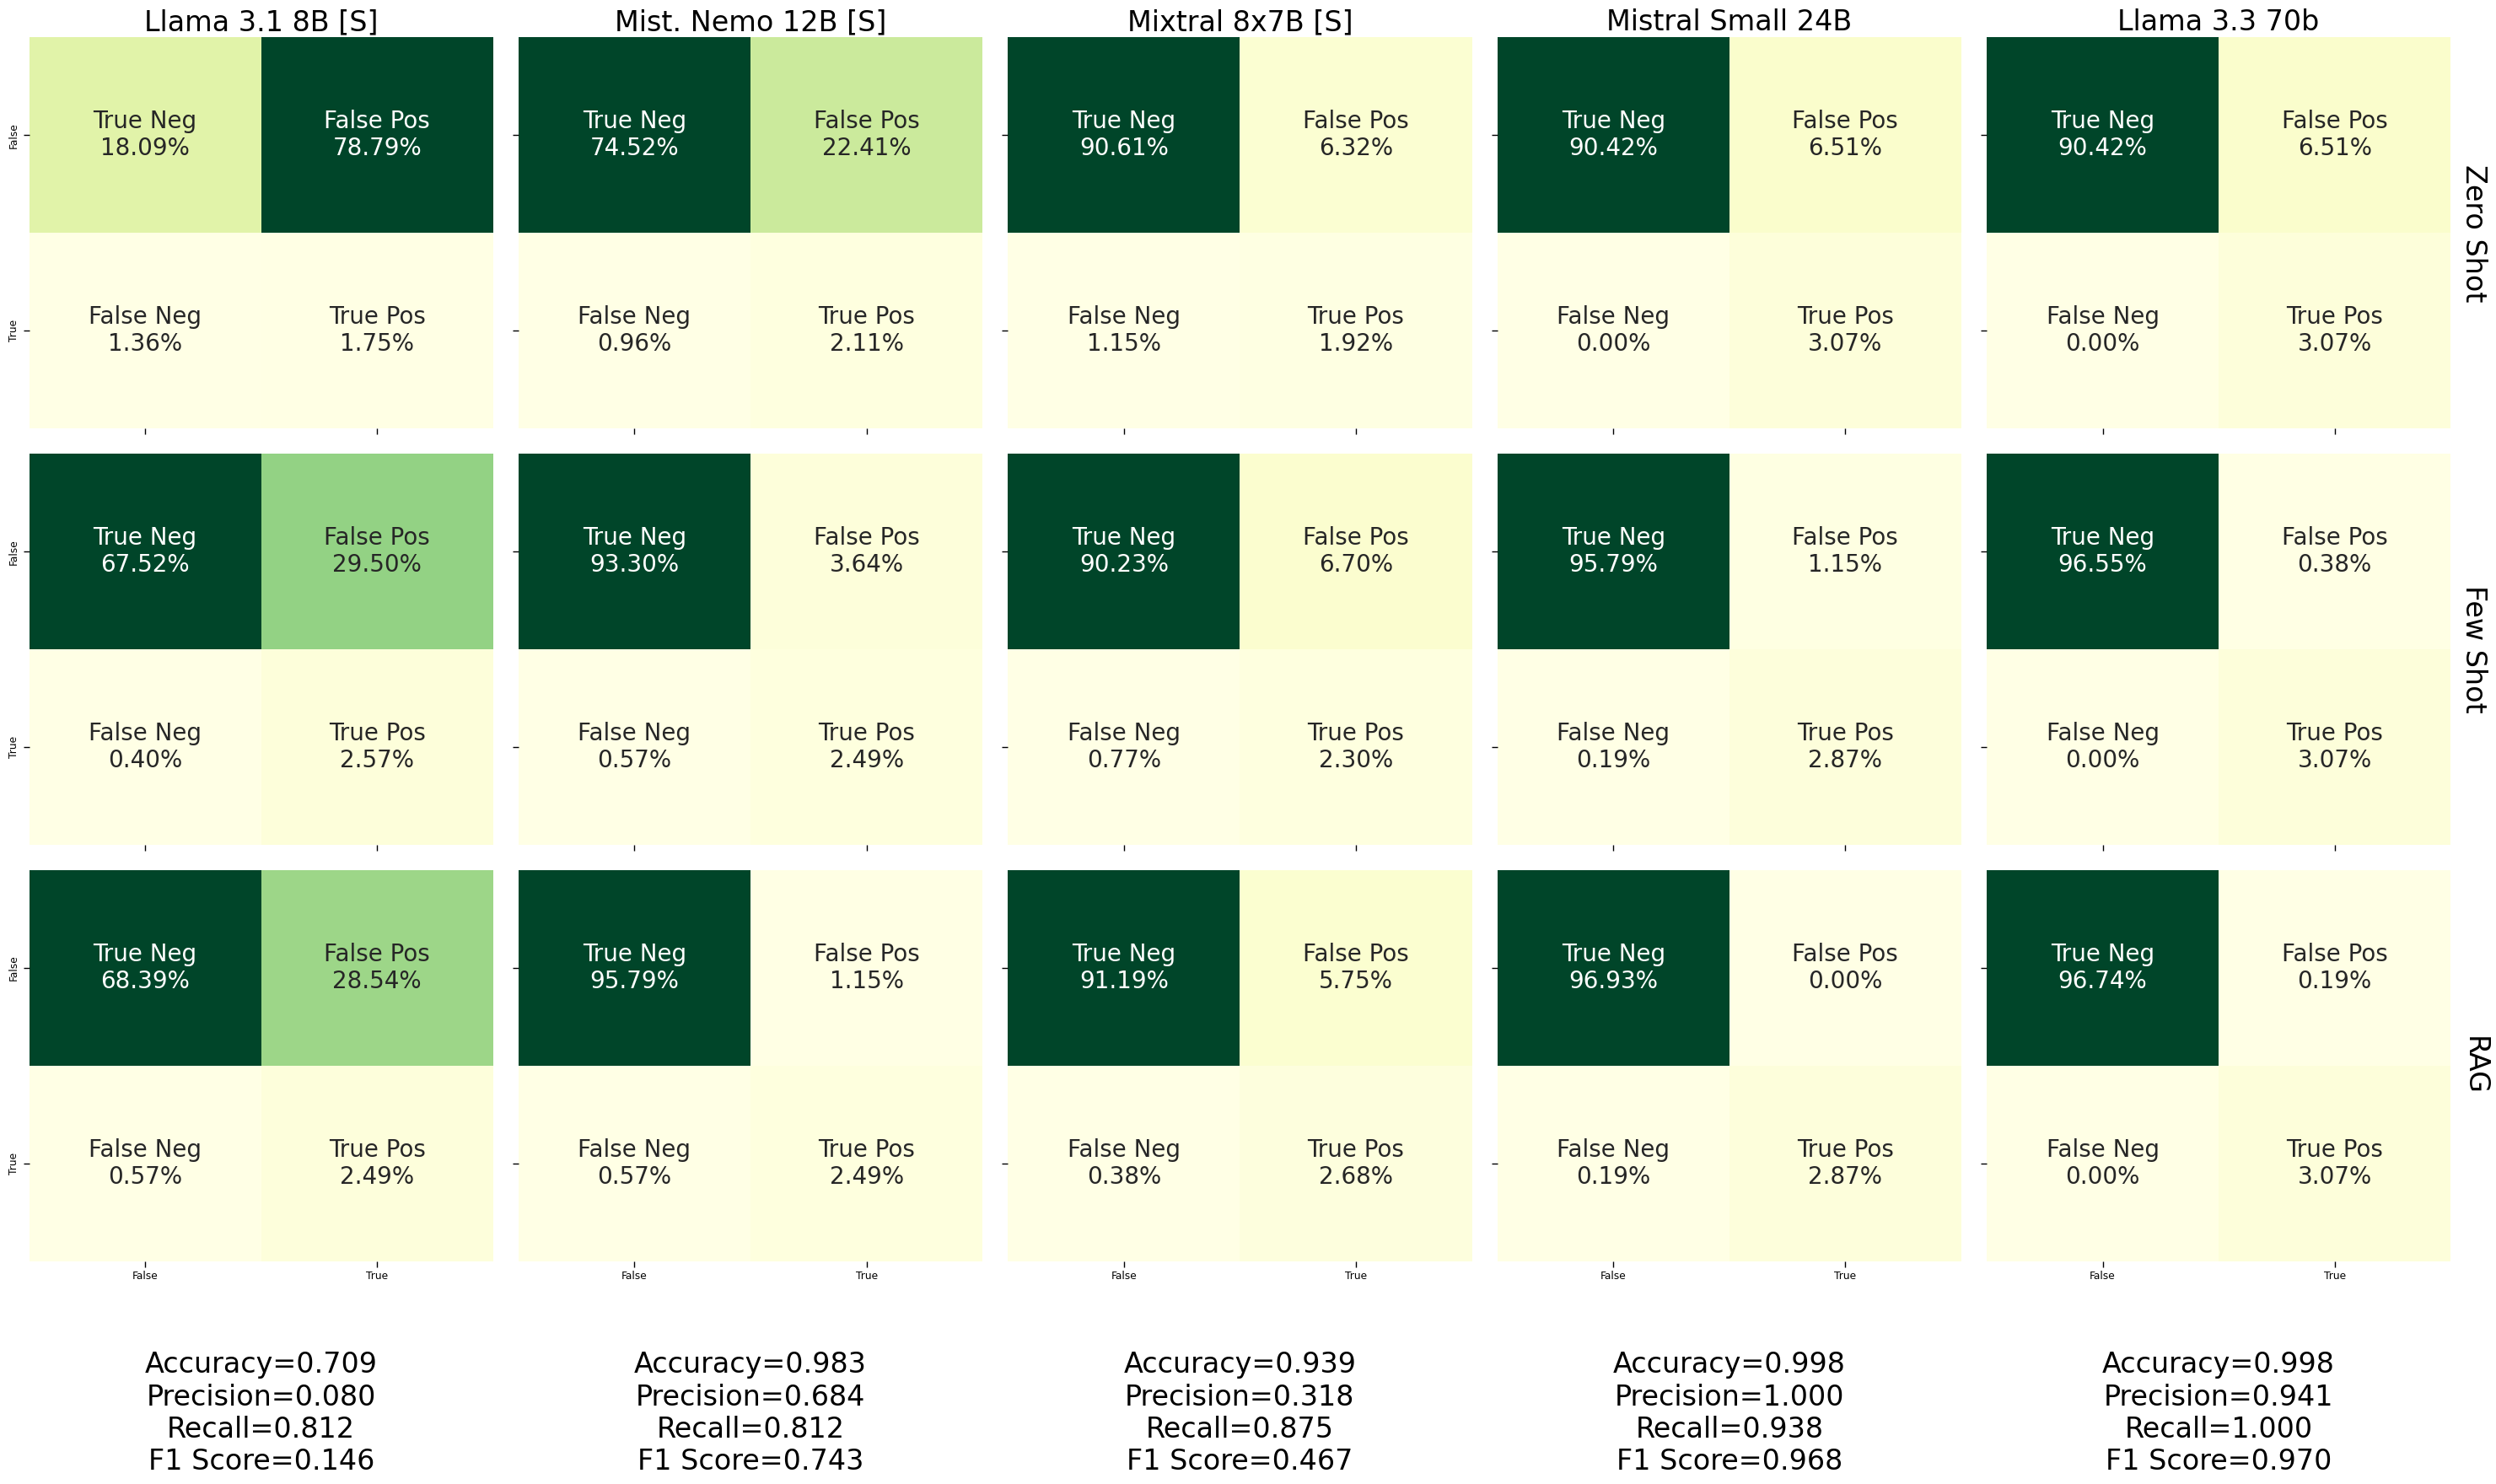

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
#['teuken7b' 'llama3_3' 'mix8x7' 'll3sauer' 'mist_nemo' 'll323b' 'deepseek_r1_8b'] "mix8x7","sauernemo",
mdata = df_final.query('Feature in ["M_STATUS"]').groupby(["LLM_Label","LLM_Order","QueryType","runid"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"])).reset_index(name="Confusion_Matrix")
#mdata = df.groupby(["runid","model"]).apply(lambda x: confusion_matrix(x["Ref_Bool"], x["Pred_Boll"],normalize='true')).reset_index(name="Confusion_Matrix")
mdata = mdata.sort_values(by=["LLM_Order","runid"])
sns.set_context("paper", rc={"font.size":20,"font.style":"italic","axes.titlesize":24,"axes.labelsize":24})
m = sns.FacetGrid(mdata,col="LLM_Label", row="QueryType", margin_titles=True, height=6)
m.set_titles(col_template="{col_name}",row_template="{row_name}")

m.map_dataframe(draw_heatmap)